In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [151]:
!cp -r /content/drive/MyDrive/ImageSegmentationData /content/image_data

In [152]:
import torchvision.transforms as transforms
import cv2
import numpy
import numpy as np
from google.colab.patches import cv2_imshow

In [153]:
import pycocotools

In [154]:
!git clone https://github.com/cfotache/pytorch_objectdetecttrack.git

Cloning into 'pytorch_objectdetecttrack'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Unpacking objects: 100% (36/36), done.


In [155]:
%cd /content/pytorch_objectdetecttrack

/content/pytorch_objectdetecttrack


In [156]:
from models import *
from utils import *
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [157]:
!chmod 755 ./config/download_weights.sh 

In [158]:
! ./config/download_weights.sh

--2021-05-20 19:04:45--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  40.5MB/s    in 6.3s    

2021-05-20 19:04:52 (37.5 MB/s) - ‘yolov3.weights.1’ saved [248007048/248007048]



In [159]:
config_path='./config/yolov3.cfg'
weights_path='/content/pytorch_objectdetecttrack/yolov3.weights'
class_path='./config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4
# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
# model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.FloatTensor

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [160]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, 
                        conf_thres, nms_thres)
    return detections[0]

Inference Time: 0:00:01.336308


<Figure size 432x288 with 0 Axes>

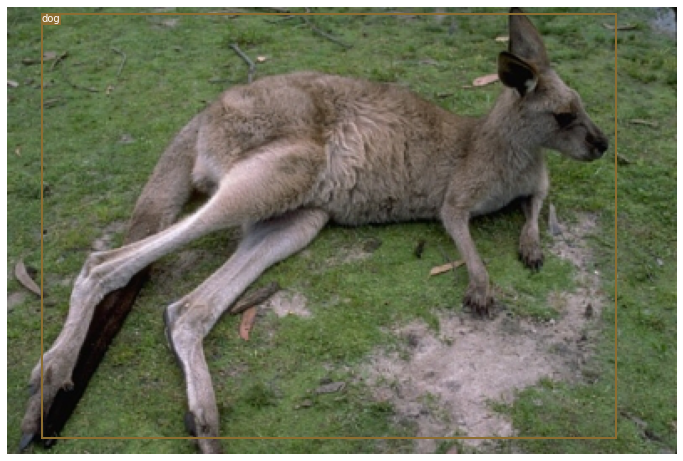

In [163]:
# load image and get detections
img_path = "/content/image_data/Image2.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))
# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]
img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

lst = []
if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        lst.append([x1,y1,x1+box_w, y1+box_h])
        color = bbox_colors[int(np.where(
             unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h,
             linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], 
                color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"),        
                  bbox_inches='tight', pad_inches=0.0)
plt.show()

In [162]:
import numpy as np
for i in range(len(lst[0])):
  lst[0][i] = lst[0][i].cpu().detach().numpy()

In [ ]:
x1 = lst[0][0]
x1 = x1.reshape(1)
x1 = x1[0]


In [ ]:
y1 = lst[0][1]
y1 = y1.reshape(1)
y1 = y1[0]

In [ ]:
x2 = lst[0][2]
x2 = x2.reshape(1)
x2 = x2[0]


In [ ]:
y2 = lst[0][3]
y2 = y2.reshape(1)
y2 = y2[0]

In [ ]:
p1 = (x1,y1)
p2 = (x2,y2)

In [ ]:
bbox = (x1,y1,x2,y2)

In [ ]:
image = cv2.imread('/content/image_data/Image2.jpg')

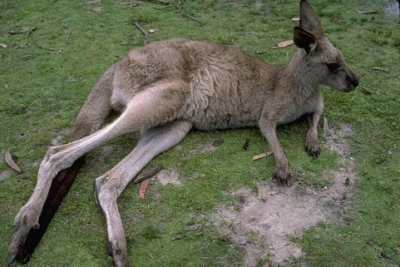

In [ ]:
cv2_imshow(image)

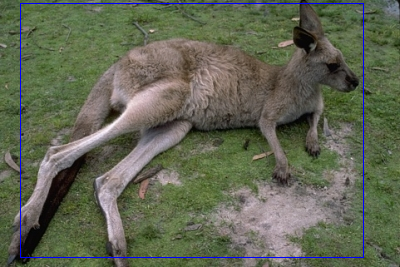

In [ ]:
im = cv2.rectangle(image.copy(), p1, p2, (255,0,0))
cv2_imshow(im)

In [ ]:
mask = np.zeros(image.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

In [ ]:
cv2.grabCut(image,mask,bbox,bgdModel,fgdModel,100,cv2.GC_INIT_WITH_RECT)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[2.13807554e-01, 2.29454664e-01, 1.62240122e-01, 1.78240993e-01,
         2.16256667e-01, 5.93903526e+01, 9.45299096e+01, 7.99460354e+01,
         8.21043050e+01, 1.18968928e+02, 1.01229483e+02, 3.95347199e+01,
         7.02312144e+01, 6.00792519e+01, 9.96345802e+01, 1.09912977e+02,
         1.11629542e+02, 7.04556436e+01, 1.06669624e+02, 9.05955707e+01,
         3.77570051e+01, 1.79622333e+01, 3.90563841e+01, 1.79622333e+01,
         4.61005754e+01, 4.15516332e+01, 3.90563841e+01, 4.15516332e+01,
         6.29525416e+01, 5.14726949e+01, 2.64268060e+01, 4.43027953e+01,
         2.64268060e+01, 4.62221133e+01, 4.42943696e+01, 4.43027953e+01,
         4.42943696e+01, 6.24787655e+01, 2.01874256e+02, 3.02970293e+02,
         2.76789390e+02, 3.02970293e+02, 5.9

In [ ]:
mask3 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
mask2 = np.where((mask==2)|(mask==0), 0, 255).astype('uint8')
output = image*mask3[:,:,np.newaxis]

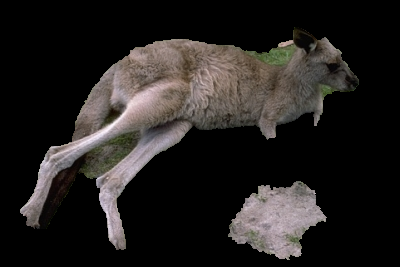

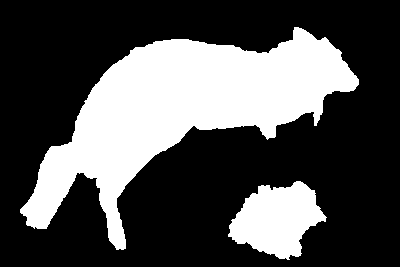

In [ ]:
cv2_imshow(output)
cv2_imshow(mask2)

In [ ]:
y_pred = mask2
y_true = cv2.imread('/content/image_data/Image1_GT.png')
y_true = cv2.cvtColor(y_true, cv2.COLOR_BGR2GRAY)

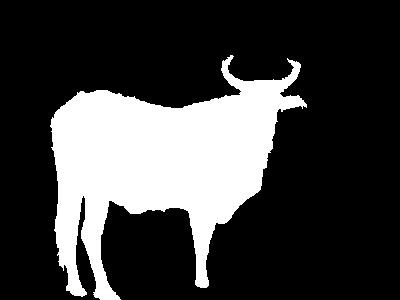

In [ ]:
cv2_imshow(y_true)

In [ ]:
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [ ]:
dice_score = dice(y_pred, y_true, k = 255) #255 in my case, can be 1 
print ("Dice Similarity: {}".format(dice_score))

Dice Similarity: 0.9640305029560449


In [ ]:
print(y_true.shape)
print(y_pred.shape)

(300, 400)
(300, 400)


In [ ]:
cv2.imwrite('/content/image_data/Image2_seg.png', y_pred)

True

In [ ]:
print(image.shape)
print(y_pred.shape)

(267, 400, 3)
(267, 400)


(267, 400, 3)


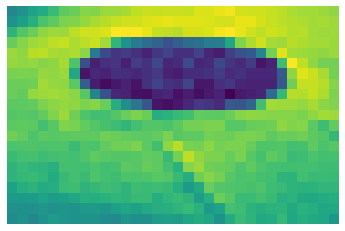

Image shape is(21, 32)
Graph from Image done in : 0.07s
Similarity Graph Shape - (3254,)
Spectral Clustering ( sklearn_spectral_clustering ) done in : 0.19s


No handles with labels found to put in legend.


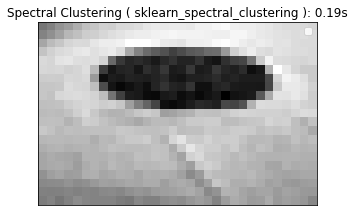

In [104]:
import time
import random
import copy
import numpy as np
import scipy as sp
import scipy.cluster.vq as vq
from numpy import linalg as la
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering as sklearn_spectral_clustering
from operator import itemgetter
from scipy import spatial

img_file = '/content/image_data/Image3.jpg'

def build_similarity_graph_from_img( img_file ):
    
    # Open Image
    img = Image.open(img_file)
    
    # '''
    # --------------------------------------
    # CODE TO RESIZE ARRAY TO 30x30 approx.
    # FOR DEBUGGING PURPOSE ENABLE THIS CODE
    # --------------------------------------
    basewidth = 32
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    # '''
    
    # Convert image to grayscale
    img = img.convert('L')
    
    # Plot grayscale image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Normalise image intensities to [0,1] values
    img = np.asarray(img).astype(float)/255.0
    print('Image shape is'  + str(img.shape))


    # Convert image into graph with the value of the gradient on the edges.
    # Gradient in this function is defined as the intensity difference relative
    # to 4 adjacent pixels for any given pixel (above, below, left and right pixels)
    graph = image.img_to_graph(img)

    # Take a decreasing function of the gradient: an exponential
    # The smaller beta is, the more independent the segmentation is of the
    # actual image. For beta=1, the segmentation is close to a voronoi
    beta = 5
    eps = 1e-6
    graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps
    
    return (graph,img)

# Function to find reciprocal of Degree matrix (D^-1)
def diag_neg( D ):
    diag_elems = np.nan_to_num( np.diagonal( D ) )
    return np.diag( np.nan_to_num( np.reciprocal( diag_elems ) ) )

# Function to find reciprocal of root of Degree matrix (D^-0.5)
def diag_neg_root( D ):
    D_root = np.sqrt( D )
    D_neg_root = diag_neg( D_root )
    return D_neg_root

# Function to find the kernel weights between 2 vectors x and u
def gaussian_kernel( x, u ):
    h = 1
    norm = np.linalg.norm(x - u)
    return np.exp(-(norm**2)/(2*(h**2)))

# Link to Landmark Based Spectral Clustering Paper : https://www.cs.cmu.edu/~xinleic/papers/aaai11.pdf
def landmark_based_SC( X, k ):
    
    p = int( np.sqrt( X.shape[0] ) )
    
    # Matrix X can be viewed as 'n' data points, each of dimension 'm'
    m,n = X.shape

    # If in Sparse COO matrix convert to array
    X = X.toarray()
            
    # Choose p points/indices without repetition from [0,n)
    U_idx = np.random.choice( range(n), p, replace=False )

    # Fill those p randomly chosen points from matrix X into U
    U = np.zeros((m,p))
    for i in range(p):
        U[:,i] = X[:,U_idx[i]]
    print(U)
            
    # Number of nearest landmark points from the 'p' points of U that we need to
    # consider for calculating U_r
    r = int(p/2)
    xi = np.zeros((m,1))
    Z = np.zeros((p,n))
    
    time_for_nw_regression = 0
    t_start = time.time()
    for i in range(n):
                
        # xi indicates every datapoint of matrix
        xi[:,0] = X[:,i]
                
        # U_r_idx populates xi's 'r' nearest vector's(datapoints) indices in U
        
        '''
        U_dist_from_xi = np.zeros((p,2))
        for j in range(p):
            U_dist_from_xi[j][0] = int(j)
            U_dist_from_xi[j][1] = np.linalg.norm(xi - U[:,j])
        
        sorted_U_dist_from_xi = np.array( sorted( U_dist_from_xi,key=itemgetter( 1 ) ) )
        U_r_idx = (sorted_U_dist_from_xi[:r][:,0]).flatten().astype(int)
        ''' 
        
        tree = spatial.KDTree(np.transpose(U))
        U_r_idx = (tree.query(np.transpose(xi),k=r)[1]).flatten()
        
        # Z_list stores gaussian kernel weights between xi and 'r' nearest
        # neighbours to xi in the matrix U
        # Nadraya Watson Kernel Regression
        Z_list = np.zeros(U_r_idx.size)
        ctr=0
        for j in U_r_idx:
            Z_list[ctr] = gaussian_kernel( xi, U[:,j] )
            ctr+=1
        
        # Normalize and fill weights in Z matrix
        ctr=0
        if( sum( Z_list ) ):
            for j in U_r_idx:
                Z[j,i] = Z_list[ctr]/sum(Z_list)
                ctr+=1

    t_end = time.time()
    time_for_nw_regression += (t_end-t_start)
    
    assert( np.isnan(Z).any() == False )
    
    D = np.diag( np.ravel( np.sum( Z, axis=1 ) ) )
    D_neg_root = diag_neg_root( D )
    
    # Compute Z_hat = D^-0.5 * Z
    Z_hat = np.dot( D_neg_root, Z )

    # SVD of Z_hat gives B_tran
    A, S, B_tran = np.linalg.svd( Z_hat, full_matrices=False )
    B = np.transpose( B_tran )


    # What B has right now would be the eigenvectors of (Z_hat * Z_hat.T)
    means, labels = vq.kmeans2(B[:,0:k],k)
    
    print('LandMark based time spent calculating nearest neighbour - ' + str(time_for_nw_regression) )
    return labels


# 2 types of Laplacian graphs
def Laplacian_graph( A, D, clustering_type='unnormalized' ):
    
    I = np.identity( A.shape[0] )
    if( clustering_type == 'unnormalized' ):
        L = D - A
        
    elif(  clustering_type == 'random_walk_normalized'  ):
        L = I - ( A / np.diagonal( D )[:,None] )
        
    return L


# Link to tutorial on Spectral Clustering : https://www.cs.cmu.edu/~aarti/Class/10701/readings/Luxburg06_TR.pdf
def spectral_clustering( graph, num_clusters, clustering_type ):
    
    k = num_clusters
    A = graph
    
    if( clustering_type == 'LANDMARK_BASED' ):
        return landmark_based_SC( A, k )
    
    elif( clustering_type == 'sklearn_spectral_clustering' ):
        return sklearn_spectral_clustering(graph, n_clusters=num_clusters,
                                           assign_labels='kmeans', random_state=1)
    
    D = np.diag( np.ravel( np.sum( A, axis=1 ) ) )

    L = Laplacian_graph( A, D, clustering_type )

    # V has matrix of all eigenvectors arranged and l has sorted eigenvalues
    l, V = la.eigh( L )

    # First K columns of V need to be clustered
    V_k_dim = V[:,0:k]
    
    U = V_k_dim

    
    if( k==2 ):
        # In this case clustering on the Fiedler vectorwhich gives very close approximation
        f = U[:,1]
        labels = np.ravel( np.sign( f ) )
        k=2
    else:
        # Run K-Means on eigenvector matrix ( Other than 0th column )
        # means --> K-means cluster centres
        # labels --> Cluster labels detected
        # Note that some times K-Means might not converge and you might have 1 cluster lesser than 'K'
        means, labels = vq.kmeans2( U[:,1:k], k )
        print(U[:,1:k].shape, labels.shape)
        
    return labels

def kMeans( graph, num_clusters ):
    
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(graph.toarray())
    #means, labels = vq.kmeans2( graph.toarray(), num_clusters )
    return kmeans.labels_

def plot_segmented_image( img, labels, num_clusters, run_time, title ):
    plt.figure( figsize=( 5, 5 ) )

    plt.imshow(img, cmap=plt.cm.gray)
    # for l in range( num_clusters ):
    #     try:
    #         plt.contour( labels == l, contours=1, colors= [plt.cm.Spectral( l / float( num_clusters ) )] )
    #     except ValueError:  #raised if `y` is empty.
    #         pass

    plt.xticks(())
    plt.yticks(())
    plt.legend(loc='best')
    if(title):
        plt.title(title + ': %.2fs' %run_time)
    else:
        plt.title('Spectral clustering: %.2fs' %run_time)
    plt.show()

    
def main():
    num_clusters = 2

    # Open image and build a similarity graph defined by a measure of similarity beteen pixels

    t0 = time.time()
    similarity_graph,img = build_similarity_graph_from_img( img_file )
    assert( similarity_graph.shape[i] == img.shape[i]**2 for i in range( 2 ) )
    t1 = time.time()

    print( 'Graph from Image done in : %.2fs' %( t1 - t0 ) )

    # Spectral clustering on the similarity graph to find a given number of clusters

    for clustering_type in [ 'sklearn_spectral_clustering']:

        t1 = time.time()
        print( 'Similarity Graph Shape - ' + str( similarity_graph.data.shape ) )
        labels = spectral_clustering( similarity_graph, num_clusters, clustering_type )
        t2 = time.time()

        print( 'Spectral Clustering ( ' + str(clustering_type) + ' ) done in : %.2fs' %( t2 - t1 ) )
    
        labels = labels.reshape( img.shape )
        plot_segmented_image( img, labels, num_clusters, (t2 - t1), 'Spectral Clustering ( ' + str(clustering_type) + ' )' )

        return labels, img

labels, img = main()

In [105]:
for i in range(len(labels)):
  for j in range(len(labels[0])):
    if(labels[i][j] == 1): labels[i][j] = 255
    else: labels[i][j] = 0

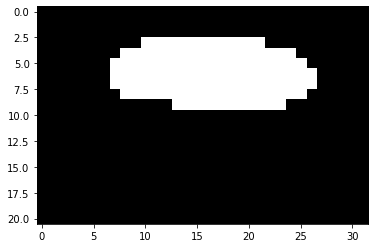

In [106]:
plt.imshow(labels, cmap = "gray")

In [134]:
plt.imsave('/content/image_data/init_seg.png', labels, cmap = 'gray')

In [135]:
image = cv2.imread('/content/image_data/init_seg.png')
print(image.shape)

(21, 32, 3)


In [136]:
 
img1 = cv2.resize(image, (400, 267),
               interpolation = cv2.INTER_CUBIC)

In [137]:
img1.shape

(267, 400, 3)

In [138]:
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

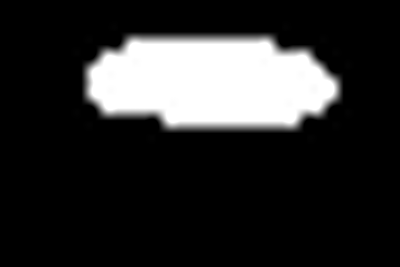

In [139]:
cv2_imshow(gray)

In [140]:
gray.shape

(267, 400)

In [141]:
cv2.imwrite('/content/image_data/Image3_seg.png', gray)

True

In [115]:
import cv2
image = cv2.imread('/content/image_data/Image3.jpg')
print(image.shape)

(267, 400, 3)
